In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm_notebook as tqdm

from scipy.special import expit

In [2]:
import pickle

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 24

In [4]:
m = 1000
n = 10

k_for_averaging = 10

In [5]:
columns = []
for i in range(n):
    columns.append('x'+str(i+1))
    
columns.append('y')
print(columns)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'y']


### Подсчет p_value для проверки H_0 в случае ее истиности и в случае истиности H_1

Найдем p_value для Wald-теста и F-теста для разного размера выборки $m$ и разного количества фиксированных параметров $n$ в случае истинности гипотезы $H_0)$ (о равенстве нулю параметров) и в случае истинности альтернативы. Также для каждой пары $(m, n)$ повторим данный эксперимент несколько раз для разных выборок.

In [6]:
all_values_w_not_H0 = []
all_values_w_H0 = []
all_values_f_not_H0 = []
all_values_f_H0 = []

list_of_m = np.arange(100, 500, 10)
list_of_n = np.arange(1, n-1, 1)

p_values_w_not_H0 = np.zeros(shape = [list_of_m.shape[0], list_of_n.shape[0], k_for_averaging])
p_values_f_not_H0 = np.zeros(shape = [list_of_m.shape[0], list_of_n.shape[0], k_for_averaging])

p_values_w_H0 = np.zeros(shape = [list_of_m.shape[0], list_of_n.shape[0], k_for_averaging])
p_values_f_H0 = np.zeros(shape = [list_of_m.shape[0], list_of_n.shape[0], k_for_averaging])

for i in tqdm(range(len(list_of_m))):
    m = list_of_m[i]
    for t in range(k_for_averaging):
        X = np.random.randn(m, n)
        
        w_not_H0 = np.random.rand(n)
        y_not_H0 = X@w_not_H0 + 0.1*np.random.randn(m)
        data_not_H0 = pd.DataFrame(np.hstack([X, y_not_H0.reshape([-1,1])]), columns = columns)
        model_not_H0 = sm.OLS.from_formula("y~x1+x2+x3+x4+x5+x6+x7+x8+x9+x10", data = data_not_H0)
        res_not_H0 = model_not_H0.fit()
  
        for j in range(len(list_of_n)):
            k = list_of_n[j]
            string = ""
            for s in columns[:n][:k]:
                string += s+'='
            string+='0'
            
            w_H0 = np.random.rand(n)
            w_H0[:k] = w_H0[:k]*0
            y_H0 = X@w_H0 + 0.1*np.random.randn(m)
            data_H0 = pd.DataFrame(np.hstack([X, y_H0.reshape([-1,1])]), columns = columns)
            model_H0 = sm.OLS.from_formula("y~x1+x2+x3+x4+x5+x6+x7+x8+x9+x10", data = data_H0)
            res_H0 = model_H0.fit()
            
            p_values_w_not_H0[i, j, t] = float(res_not_H0.wald_test(string, use_f=False).pvalue)
            p_values_f_not_H0[i, j, t] = float(res_not_H0.f_test(string).pvalue)
            
            p_values_w_H0[i, j, t] = float(res_H0.wald_test(string, use_f=False).pvalue)
            p_values_f_H0[i, j, t] = float(res_H0.f_test(string).pvalue)
            
            

### Построение поверхностии для p_value
Построем поверхность зависимости p_value в каждой точке (m, n).

In [7]:
Averaging_p_values_w_not_H0 = np.mean(p_values_w_not_H0, axis = -1)
Averaging_p_values_f_not_H0 = np.mean(p_values_f_not_H0, axis = -1)

Averaging_p_values_w_H0 = np.mean(p_values_w_H0, axis = -1)
Averaging_p_values_f_H0 = np.mean(p_values_f_H0, axis = -1)

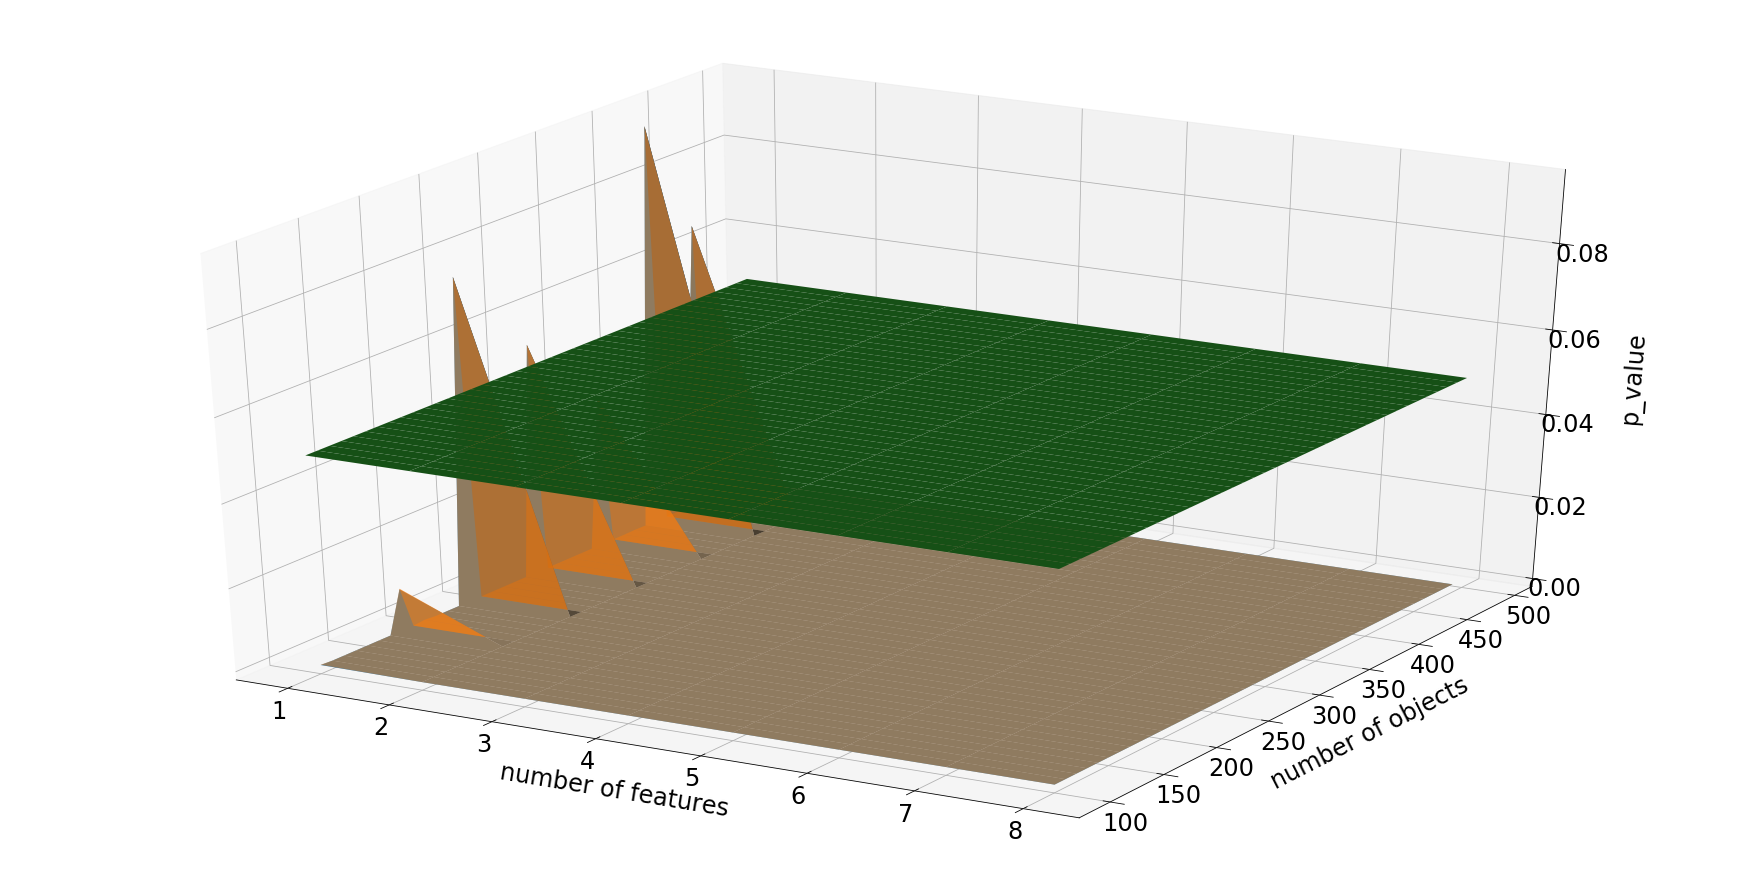

In [8]:
xgrid, ygrid = np.meshgrid(list_of_n, list_of_m)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, Averaging_p_values_w_not_H0, alpha = 1, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, Averaging_p_values_f_not_H0, alpha = 0.5, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, 0.05+0*Averaging_p_values_f_not_H0, label = '$p_value = 0.05$')



axes.set_xlabel('number of features', labelpad=24)
axes.set_ylabel('number of objects', labelpad=24)
axes.set_zlabel('p_value', labelpad=24)

plt.grid()
plt.show()

Как видно из графика оба теста работают похоже, и почти во всех точках в случае истинности альтернативной гипотезы, нулевая гипотеза отвергается на уровне значимости 0.05. 

(На рис: зеленная поверхность это поверхность отвечающая уровню значимости 0.05, оранджевая поверхность отвечает F-тесту, синяя поверхность отвечает Wald-тесту)

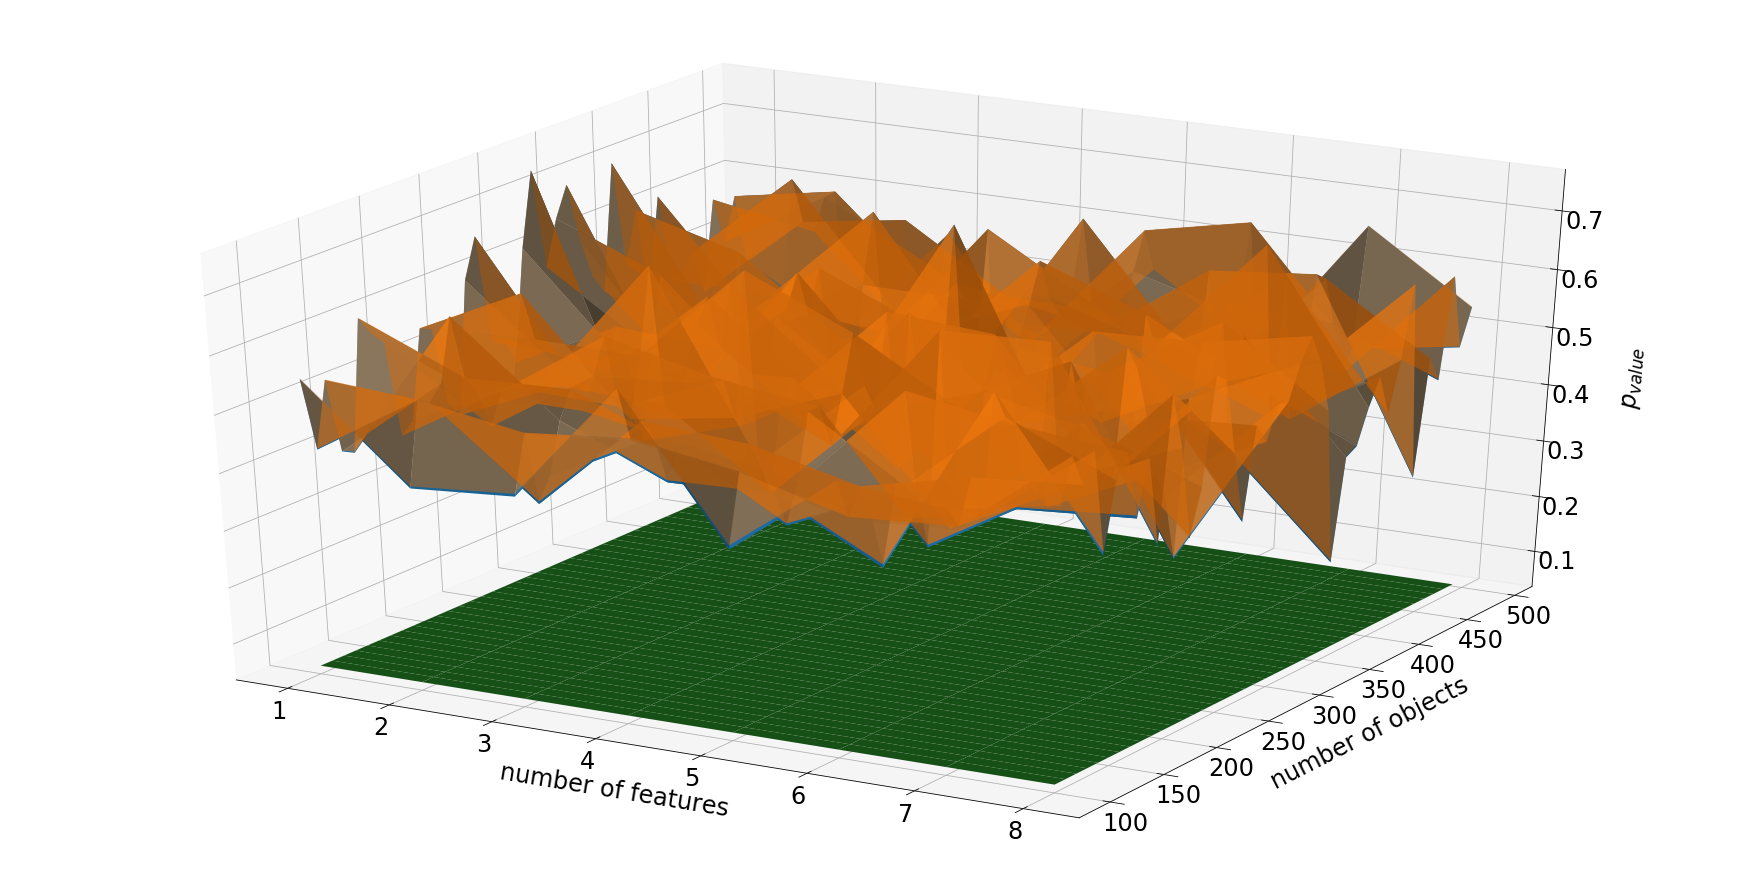

In [9]:
xgrid, ygrid = np.meshgrid(list_of_n, list_of_m)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, Averaging_p_values_w_H0, alpha = 1, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, Averaging_p_values_f_H0, alpha = 0.5, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, 0.05+0*Averaging_p_values_f_not_H0, label = '$p_value = 0.05$')

axes.set_xlabel('number of features', labelpad=24)
axes.set_ylabel('number of objects', labelpad=24)
axes.set_zlabel('$p_{value}$', labelpad=24)

plt.grid()
plt.show()

Как видно из графика оба теста работают похоже, и почти во всех точках в случае истинности нулевой гипотезы, нулевая гипотеза не может быть отвергнута на уровне значимости 0.05. 

(На рис: зеленная поверхность это поверхность отвечающая уровню значимости 0.05, оранджевая поверхность отвечает F-тесту, синяя поверхность отвечает Wald-тесту)

### Построение поверхностии для консервативности и мощности
Построем поверхность зависимости консервативности и мозности в каждой точке (m, n).

In [10]:
Conservity_w_not_H0 = np.mean(p_values_w_not_H0 < 0.05, axis = -1)
Conservity_f_not_H0 = np.mean(p_values_f_not_H0 < 0.05, axis = -1)

Conservity_w_H0 = np.mean(p_values_w_H0 > 0.05, axis = -1)
Conservity_f_H0 = np.mean(p_values_f_H0 > 0.05, axis = -1)

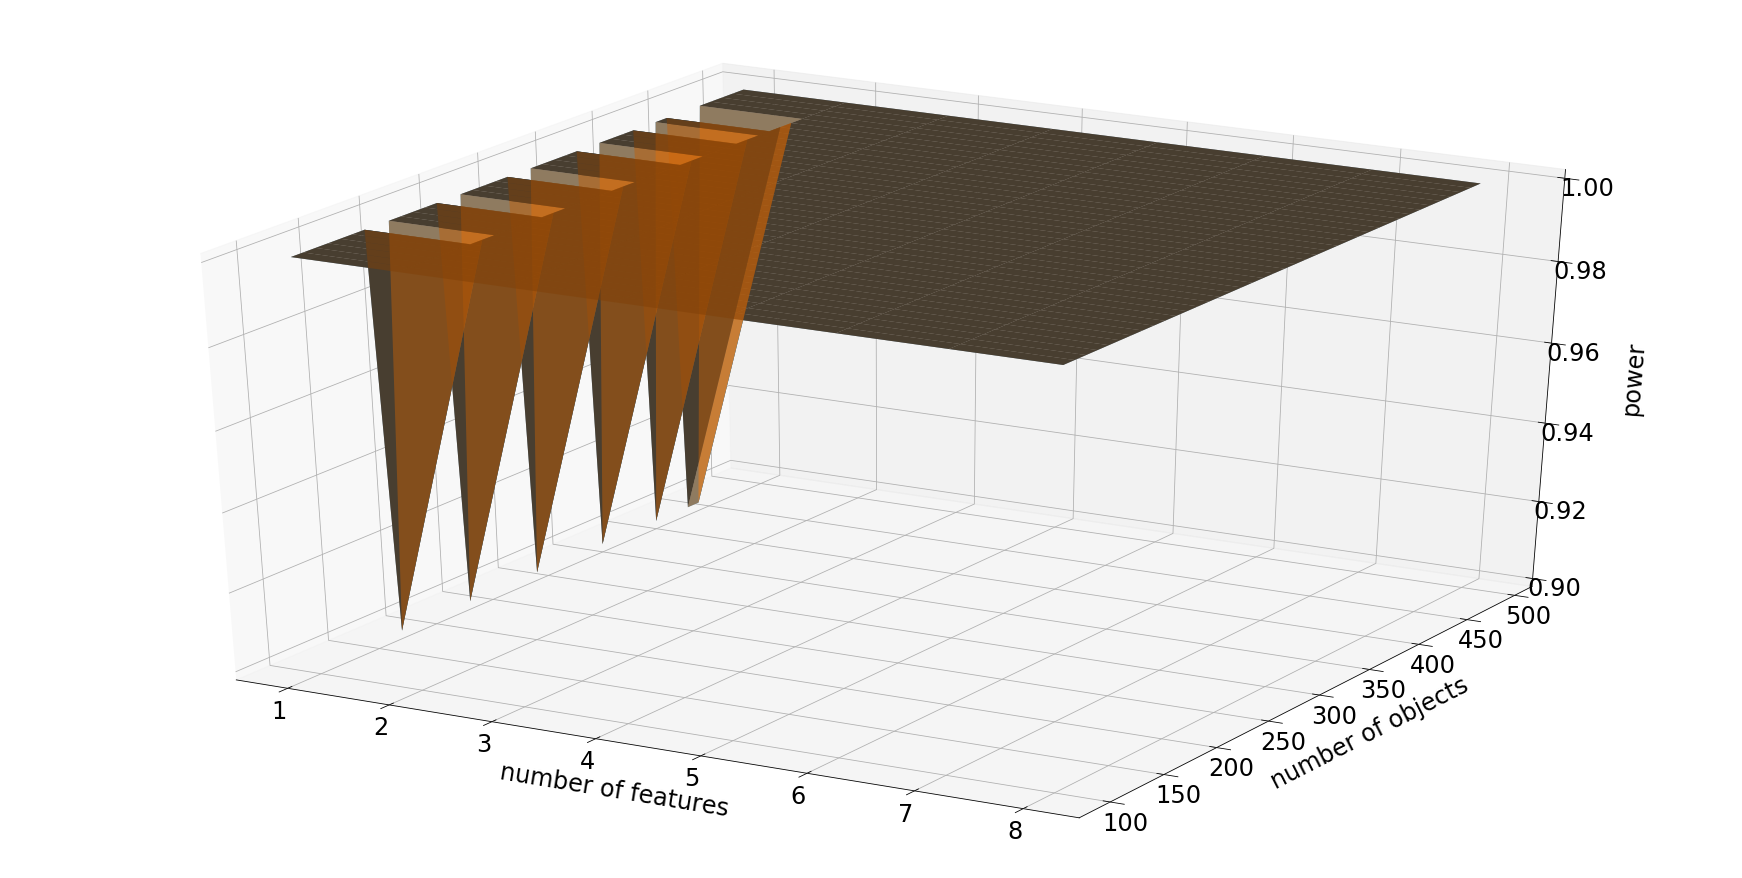

In [11]:
xgrid, ygrid = np.meshgrid(list_of_n, list_of_m)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, Conservity_w_not_H0, alpha = 1, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, Conservity_f_not_H0, alpha = 0.5, label = '$p_value$')

axes.set_xlabel('number of features', labelpad=24)
axes.set_ylabel('number of objects', labelpad=24)
axes.set_zlabel('power', labelpad=24)

plt.grid()
plt.show()

Как видно из графика, мощность критерия для обоих тестов аналогичная, так-как почти при каждой паре (m, n) близка к $1$. 

(На рис: оранджевая поверхность отвечает F-тесту, синяя поверхность отвечает Wald-тесту)

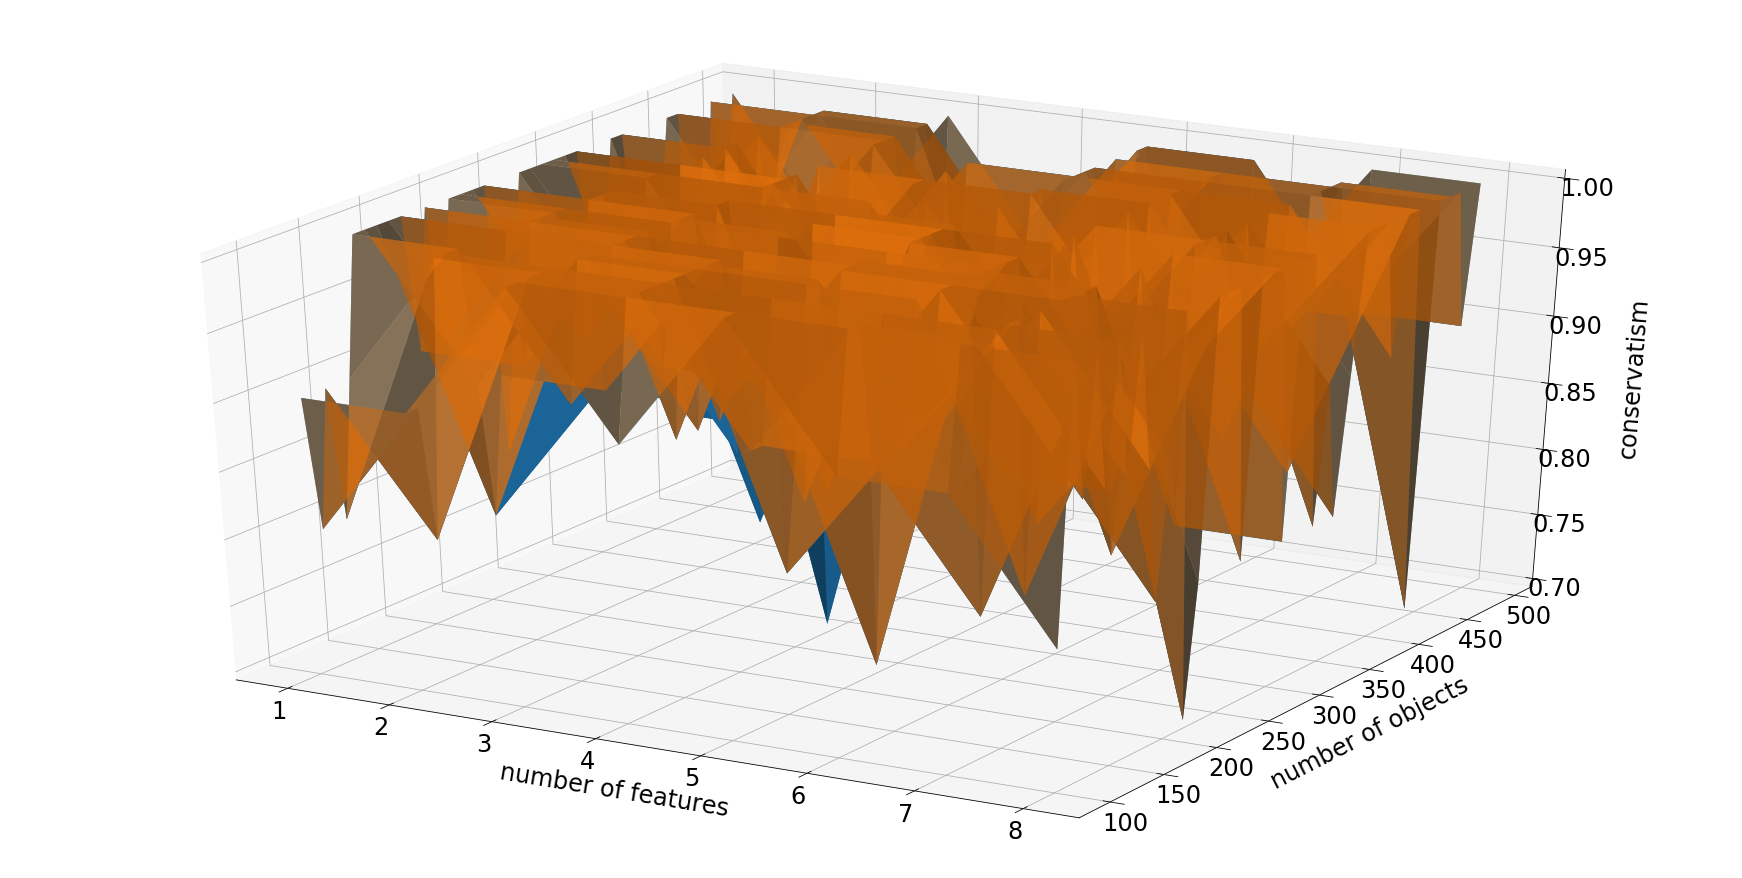

In [12]:
xgrid, ygrid = np.meshgrid(list_of_n, list_of_m)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, Conservity_w_H0, alpha = 1, label = '$p_value$')
axes.plot_surface(xgrid, ygrid, Conservity_f_H0, alpha = 0.5, label = '$p_value$')

axes.set_xlabel('number of features', labelpad=24)
axes.set_ylabel('number of objects', labelpad=24)
axes.set_zlabel('conservatism', labelpad=24)

plt.grid()
plt.show()

Как видно из графика, консерватиновность обоих тестов похожая, так-как почти при каждой паре (m, n) больше $0.6$. Причем обе поверзности ведут себя одинаково, явных фаворитов нету. Но в некоторых точках видим, что Wald-тест менее консервативный.

(На рис: оранджевая поверхность отвечает F-тесту, синяя поверхность отвечает Wald-тесту)

### Вывод

Эксперимент показал, что оба метода работают аналогично, но в некоторых случаях консервативность F-теста лучше чем консервативность Wald-теста. В случае, когда проверяется на равенство один параметр, тогда Wald-тест использует нормальное распределение и как следствие получаем, что качество значительно отличается от $1$, в случае, когда у нас фиксируется $2$ и более параметра, тогда Wald-тест использует $\chi^2$ распределение, и получаем мощность близкую к $1$. В случае F-теста все аналогично.